In [61]:

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
import math 

import sklearn.metrics as metrics
from sklearn.dummy import DummyRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, HuberRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet


from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import scale
from sklearn.feature_selection import RFE



# import ImbalancedLinearRegression as iblr

from sklearn.decomposition import PCA

from scipy import stats
from scipy.stats import kurtosis, skew

import seaborn as sns

%matplotlib inline


In [2]:
def load_dataset(data):
    df = pd.read_csv(data)
   
    return df


In [3]:
df_fb= load_dataset('cleaned_files/football_clean_supervised.csv')
df_fb.head(2)
# df_fb.shape  #(1263, 24)

,Unnamed: 0,NAME,GRADE,AGE,SKILL,STARCOLL,NUMOFF,POS,HEIGHT_IN,WEIGHT_LBS,...,TIK_LONG,TOT_FOL,SPORT,RECRUIT_YEAR,EXP_MONTHS,EXP_YEARS,institution_name_short,ClassificationCode,REV_MEN,EXP_MEN
0,0,Arch Manning,2.0,18.28281,99.53,Texas,18.0,1.0,75.5,220.0,...,8900.0,73900.0,football,2023.0,2.0,0.189041,Texas,1.0,161532860.0,50633156.0
1,1,Anthony Hill,2.0,18.00000,97.87,Texas,25.0,8.0,73.5,225.0,...,0.0,13100.0,football,2023.0,2.0,0.189041,Texas,1.0,161532860.0,50633156.0


In [4]:
df_bb= load_dataset('cleaned_files/basketball_clean_supervised.csv')
df_bb.head(2)
# df_bb.shape  #(137, 24)
df_bb.columns

Index(['Unnamed: 0', 'NAME', 'GRADE', 'AGE', 'SKILL', 'STARCOLL', 'NUMOFF',
       'POS', 'HEIGHT_IN', 'WEIGHT_LBS', 'COLLDIST_MI', 'NILVAL_LONG_USD',
       'INSTA_LONG', 'TWIT_LONG', 'TIK_LONG', 'TOT_FOL', 'SPORT',
       'RECRUIT_YEAR', 'EXP_MONTHS', 'EXP_YEARS', 'institution_name_short',
       'ClassificationCode', 'REV_MEN', 'EXP_MEN'],
      dtype='object')

In [5]:
##save athlete names for later indexing
fb_athletes = df_fb['NAME']
bb_athletes = df_bb['NAME']

# athlete_names
#remove Unnamed:0, NAME, SPORT, STARCOLL, institution_name_short- not necessary
#remove EXP_YEAR- similar to EXP_MONTHS
df_bb = df_bb.drop(columns=['Unnamed: 0', 'NAME','SPORT','STARCOLL','EXP_YEARS','institution_name_short'])
df_fb= df_fb.drop(columns=['Unnamed: 0', 'NAME','SPORT', 'STARCOLL','EXP_YEARS','institution_name_short'])
print("Basketball dataset shape: {}, Football dataset shape: {}".format(df_bb.shape,df_fb.shape))





Basketball dataset shape: (137, 18), Football dataset shape: (1263, 18)


**EDA**

Looking for imbalance in target value (NILVAL_LONG_USD). Approach will be to log transform target value. 

Text(0.5, 1.0, 'Basketball - NILVAL_LONG_USD (Binning: 10)')

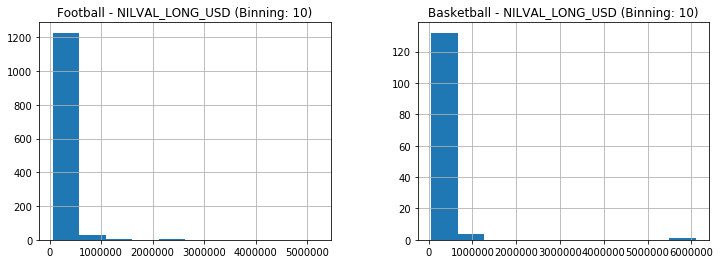

In [6]:
# df_fb['NILVAL_LONG_USD'].hist(bins=10)
# df_bb['NILVAL_LONG_USD'].hist(bins=10)

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

df_fb.hist('NILVAL_LONG_USD', bins=10, ax=axes[0])
axes[0].set_title('Football - NILVAL_LONG_USD (Binning: 10)')
df_bb.hist('NILVAL_LONG_USD', bins=10, ax=axes[1])
axes[1].set_title('Basketball - NILVAL_LONG_USD (Binning: 10)')

In [7]:
# sns.pairplot (df_fb, kind ='reg')

In [8]:
# sns.pairplot(df_bb, kind = 'reg')

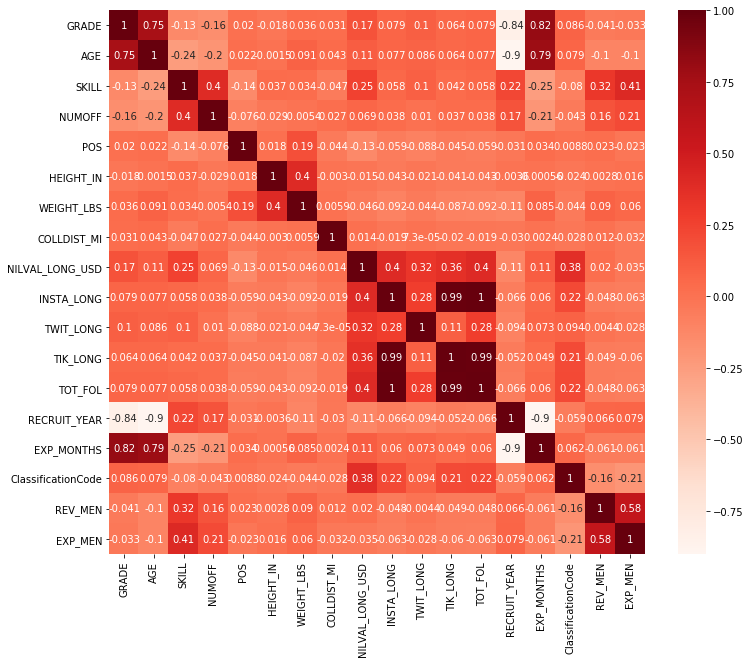

In [9]:
plt.figure(figsize=(12,10))
cor = df_fb.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

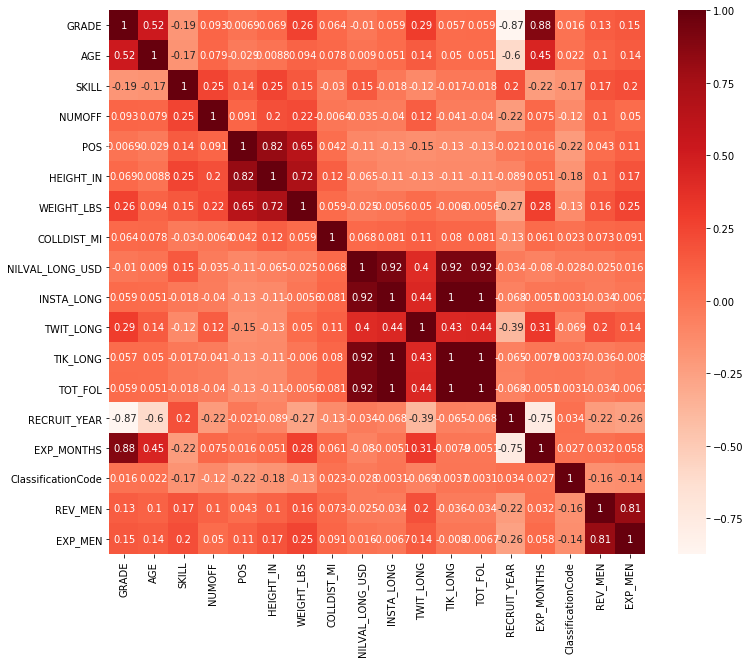

In [10]:
plt.figure(figsize=(12,10))
cor2 = df_bb.corr()
sns.heatmap(cor2, annot=True, cmap=plt.cm.Reds)
plt.show()

Looking like there is some high correlation with Recruit year and other features (GRADE, EXP MONTHS) and TOT_FOL with othe social media counts
Let's drop this features

In [11]:
df_fb=df_fb.drop(columns= ['RECRUIT_YEAR', 'TOT_FOL']).copy()
df_bb=df_bb.drop(columns=['RECRUIT_YEAR','TOT_FOL']).copy()

In [12]:
#Correlation heatmap
#https://stackoverflow.com/questions/72213733/how-to-plot-seaborn-heatmap-for-target-vs-independent-features
#+1= highly and positively correlated and -1 = highly negatively correlated.
def corr_plot(df):
    corr_matrix = df.corr()
    data=pd.DataFrame(corr_matrix['NILVAL_LONG_USD'].sort_values(ascending=False))  #plotting all but could do top (>.50)
    plt.figure(figsize = (10,10))
    return  sns.heatmap(data, annot=True, vmin=-1, vmax=1, cmap='bwr')
    # ax.tick_params(labelrotation=0)


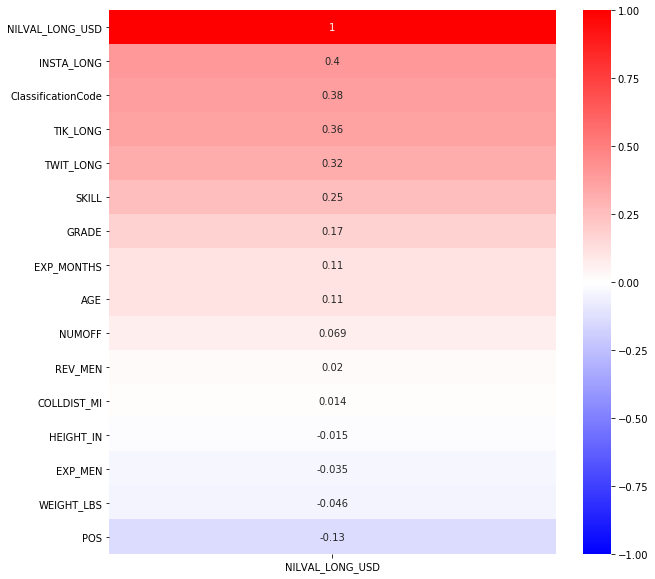

In [13]:
corr_plot(df_fb)

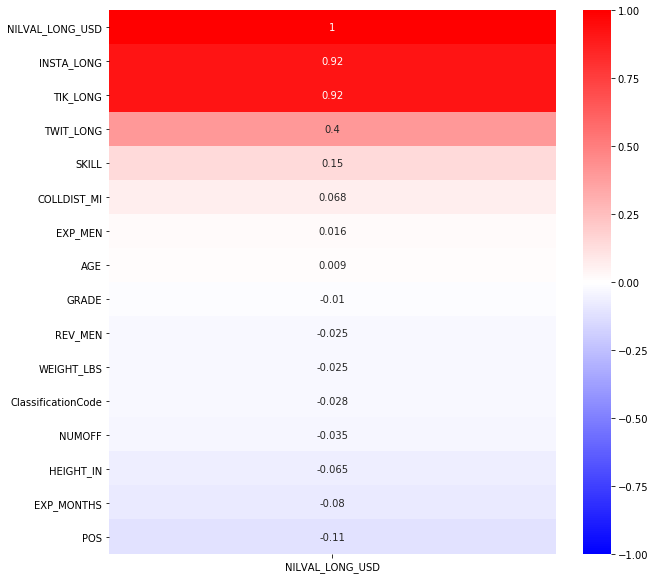

In [14]:
corr_plot(df_bb)

Given skewed NILVAL_LONG_USD - take log of y

**Using Custom Train_Test_Split** Is this affecting model performance?? Modified to do log of y

In [15]:

def custom_train_test_split(df, train_size_=0.70, valid_size_=0.15, test_size_=0.15,RANDOM_STATE=0):
    """
    :: Input(s) ::
        df - a dataframe containing all of the features and the target feature
        valid_size - the subset of the remaining training set after the test set was formed
        test_size - the size ofthe validation when compared to the training set
        RANDOM_STATE - a random state for this function to promote repeatability
    :: Output(s) ::
        X_train - training feature dataframe
        X_valid - validation feature dataframe
        X_test - testing feature dataframe
        y_train - training target feature
        y_valid - validation target feature
        y_test - testing target feature
    :: Function Description ::
        'custom_train_test_split' looks to take a cleaned dataframe and split it into the various training, validating, and testing datasets.
    """
    # Transform the continuous "SKILL_" column into a categorical such that it could be binned
    # bins = [0, 80, 85, 90, 95, 100]
    # labels = [
    #     "Very Low Skill",
    #     "Low Skill",
    #     "Medium Skill",
    #     "High Skill",
    #     "Very High Skill",
    # ]
    # df = df.copy()
    # df["SKILL_CAT"] = pd.cut(df["SKILL"], bins=bins, labels=labels).astype(str)

    
    bins =  4
    df['SKILL_CAT'] = pd.cut(df['SKILL'],bins=bins,labels=False)

    # Shuffle the dataframe
    df = df.sample(frac=1, random_state=RANDOM_STATE)

    # Get our X and y arrays/ Target Feature: NILVAL_LONG_USD

    y = df.pop("NILVAL_LONG_USD")
    y= np.log1p(y)
    X = df



#Produce train 70% / rest 30% (validation  & test)
    X_train, X_remaining, y_train, y_remaining,  = train_test_split(
        X,
        y,
        test_size = (1-train_size_),
          stratify=X["SKILL_CAT"],
        random_state=RANDOM_STATE,
    )



# NEW -Split remaining 30% by 0.5 to get 15% each validation and test
    rel_test_size_= test_size_ / (valid_size_ + test_size_)

    X_valid, X_test, y_valid, y_test = train_test_split(
        X_remaining,
        y_remaining,
        test_size= rel_test_size_,
        stratify=X_remaining["SKILL_CAT"],
        random_state=RANDOM_STATE,
    )

    # Ensure y_train, y_valid, and y_test are 1D arrays or Series
    y_train = y_train.squeeze()  # Convert to 1D array
    y_valid = y_valid.squeeze()  # Convert to 1D array
    y_test = y_test.squeeze()    # Convert to 1D array

    return X_train, y_train, X_valid, y_valid, X_test, y_test


In [16]:


# X_train_bb, y_train_bb, X_valid_bb, y_valid_bb, X_test_bb, y_test_bb = custom_train_test_split(df_bb)
# X_train_fb, y_train_fb, X_valid_fb, y_valid_fb, X_test_fb, y_test_fb = custom_train_test_split(df_fb)

# print((X_train_bb.shape,y_train_bb.shape ),(X_valid_bb.shape, y_valid_bb.shape),(X_test_bb.shape, y_test_bb.shape))
# print((X_train_fb.shape,y_train_fb.shape ),(X_valid_fb.shape, y_valid_fb.shape),(X_test_fb.shape, y_test_fb.shape))
    


**Train Test Split- NOT CUSTOM**

In [17]:

def split_data(df, train_size_=0.70, valid_size_=0.15, test_size_=0.15, random_state=42):
    # Log-transform y
    y = df.pop("NILVAL_LONG_USD")
    y = np.log1p(y)
    X = df

    # Split the data
    X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=valid_size_ + test_size_, 
    shuffle = True, random_state=random_state)
    X_valid, X_test, y_valid, y_test = train_test_split(X_temp, y_temp, test_size=test_size_ / (valid_size_ + test_size_), shuffle = True, random_state=random_state)

    return X_train, y_train, X_valid, y_valid, X_test, y_test

In [18]:


# # def split_data(df, train_size_=0.70, valid_size_=0.15, test_size_=0.15, random_state=42):
    
# #     #log transform y
# #     y = df.pop('NILVAL_LONG_USD')
# #     y = np.log1p(y)
#     X = df
    
#     # Split the data into train and remaining (30%)
#     X_train, X_remaining, y_train, y_remaining = train_test_split(
#         X,
#         y,
#         test_size=(1 - train_size_),
#         random_state=random_state,
#         shuffle=True,
#     )

#     # Split the remaining 30% into validation and test (15% each)
#     rel_test_size_ = test_size_ / (valid_size_ + test_size_)

#     X_valid, X_test, y_valid, y_test = train_test_split(
#         X_remaining,
#         y_remaining,
#         test_size=rel_test_size_,
#         random_state=random_state,
#         shuffle=True,
#     )

#     # Ensure y_train, y_valid, and y_test are 1D arrays or Series
#     y_train = y_train.squeeze().copy()  # Convert to 1D array
#     y_valid = y_valid.squeeze()  # Convert to 1D array
#     y_test = y_test.squeeze()    # Convert to 1D array
    
#     return X_train, X_valid, X_test, y_train, y_valid, y_test


In [19]:
X_train_bb, y_train_bb, X_valid_bb, y_valid_bb, X_test_bb, y_test_bb = split_data(df_bb)
X_train_fb, y_train_fb, X_valid_fb, y_valid_fb, X_test_fb, y_test_fb = split_data(df_fb)

print((X_train_bb.shape,y_train_bb.shape ),(X_valid_bb.shape, y_valid_bb.shape),(X_test_bb.shape, y_test_bb.shape))
print((X_train_fb.shape,y_train_fb.shape ),(X_valid_fb.shape, y_valid_fb.shape),(X_test_fb.shape, y_test_fb.shape))



((95, 15), (95,)) ((21, 15), (21,)) ((21, 15), (21,))
((884, 15), (884,)) ((189, 15), (189,)) ((190, 15), (190,))


In [20]:
print((X_train_fb.shape,y_train_fb.shape ),(X_valid_fb.shape, y_valid_fb.shape),(X_test_fb.shape, y_test_fb.shape))

((884, 15), (884,)) ((189, 15), (189,)) ((190, 15), (190,))


**Functions- Result Metrics, Dummy Regressor**

In [54]:
#regression results

#https://stackoverflow.com/questions/26319259/how-to-get-a-regression-summary-in-scikit-learn-like-r-does
def regression_results(y_true, y_pred):

       # Regression metrics
    # explained_variance=metrics.explained_variance_score(y_true, y_pred)
    mae = round(metrics.mean_absolute_error(y_true, y_pred), 4)
    mse = metrics.mean_squared_error(y_true, y_pred)
    mse = round(mse,4)
    rmse = np.sqrt(mse)
    rmse = round(rmse,4)
    r2 = round(metrics.r2_score(y_true, y_pred), 4)

  
    return mae, mse, rmse, r2



In [56]:
#Dummy Regressor
def dummy_reg(name,X_train,y_train,X_test,y_test):
    name = name
    #create Dummy Regressor, fit
    mean_dummy = DummyRegressor(strategy="mean").fit(X_train, y_train)

    #make predictions
    y_pred = mean_dummy.predict(X_test)

# Reverse the log transformation to obtain predictions on the original scale
    y_pred = np.expm1(y_pred)
    y_pred= np.round(y_pred,0)
    y_actual = np.expm1(y_test)

    mae, mse, rmse, r2 = regression_results(y_actual, y_pred)

    return {
        # "Model Name": "Dummy Regressor",
        "{} Results".format(name): {
            "Model Name": "Dummy Regressor",
            "test R_Squared": r2,
            "test RMSE": rmse,
            "test MSE": mse,
            "test MAE": mae,
            
        }
    }, y_pred, y_actual





In [57]:
#y_predicted and y_actual transformed back -log reversed in function above
results_drbb, y_pred_drbb, y_actual_drbb = dummy_reg('basketball',X_train_bb,y_train_bb,X_test_bb,y_test_bb)
results_drfb, y_pred_drfb, y_actual_drfb = dummy_reg('football', X_train_fb,y_train_fb,X_test_fb,y_test_fb)

dummyreg_bb = pd.DataFrame(results_drbb)
dummyreg_fb = pd.DataFrame(results_drfb)
# print(dummyreg_bb.T, dummyreg_fb.T)

from IPython.display import display
display(dummyreg_bb.T)
display(dummyreg_fb.T)

,Model Name,test MAE,test MSE,test RMSE,test R_Squared
basketball Results,Dummy Regressor,91537.5714,11139467210.5238,105543.6744,-0.2189


,Model Name,test MAE,test MSE,test RMSE,test R_Squared
football Results,Dummy Regressor,65759.9158,18983763687.578999,137781.5796,-0.0478


If RMSE > MSE, it suggests that the model is sensitive to larger errors in its predictions, which can be important to know if large errors have a more significant impact on the problem at hand.
<br>If RMSE > MAE, it suggests that the model has a tendency to produce larger errors and that these errors significantly impact the overall performance evaluation.
<br>MSE provides a single numerical value that indicates how well the model's predictions align with the actual data. Lower MSE values suggest a better fit between the model and the data.
<br>The smaller the MAE, the better the model's predictions align with the actual data. A smaller MAE indicates a more accurate model.

MAE is often used when the absolute magnitude of errors is more critical than their direction (overestimation or underestimation). It treats all errors with equal importance.

MAE is expressed in the same units as the target variable, making it easy to interpret.
<br>Lower RMSE values indicate a better fit between the model and the data. In other words, a smaller RMSE suggests that the model's predictions are closer to the actual values.

RMSE is more sensitive to outliers compared to the Mean Absolute Error (MAE) because it considers squared differences and gives more weight to larger errors.

RMSE is suitable when you want to measure the accuracy of predictions while considering the magnitude of errors. It penalizes larger errors more significantly.

**Visualization Functions**

In [24]:
def plot_regression_results(y_actual, y_predicted, model_name):
    
    plt.figure(figsize=(10, 6))
    sns.regplot(x=y_actual, y=y_predicted,color = 'blue', line_kws=dict(color="r"))
    plt.xlabel("Actual NIL Values")
    plt.ylabel("Predicted NIL Values")
    plt.title(f'{model_name}: Actual vs. Predicted NIL Values')
    plt.xlim(0, max(y_actual))
    plt.ylim(0, max(y_actual))
    plt.show()


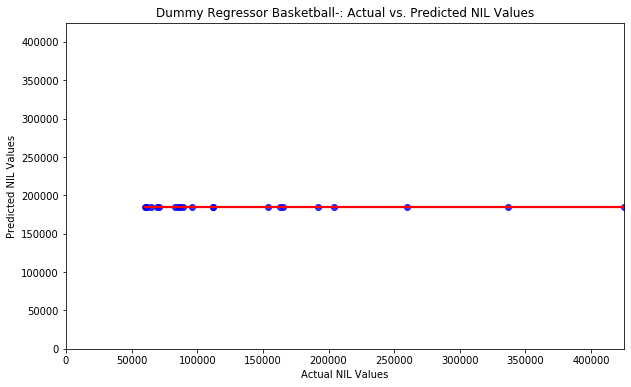

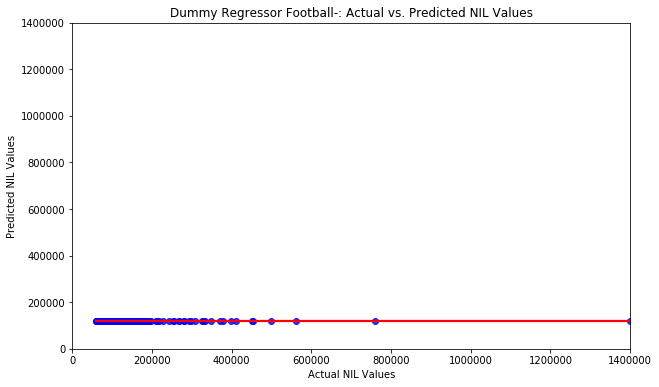

In [25]:

#pass test actual, predicted, model name
plot_regression_results(y_actual_drbb,  y_pred_drbb, 'Dummy Regressor Basketball-')

plot_regression_results(y_actual_drfb,  y_pred_drfb, 'Dummy Regressor Football-')


In [26]:
# # Create residual plot with actual and predicted values
# sns.residplot(x=y_test_orig_dr, y=y_test_pred_orig_dr, scatter_kws={'s': 10}, line_kws={'color': 'red'})
# plt.xlabel('Predicted Values')
# plt.ylabel('Residuals')
# plt.title('Residual Plot')
# plt.show()

def create_residual_plot(name, y_actual, y_predicted):
    name = name 
    sns.residplot(x=y_predicted, y=y_actual, scatter_kws={'s': 10}, line_kws={'color': 'red'})
    plt.xlabel('Predicted Values')
    plt.ylabel('Residuals')
    plt.title('{} Residual Plot'.format(name))
    plt.show()

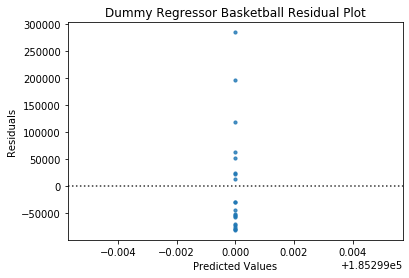

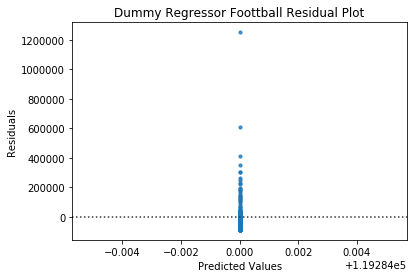

In [28]:
create_residual_plot('Dummy Regressor Basketball',y_actual_drbb, y_pred_drbb)
create_residual_plot('Dummy Regressor Foottball',y_actual_drfb, y_pred_drfb)

In [34]:


def create_residual_histogram(name, y_actual, y_predicted):

    residuals = y_actual - y_predicted
    plt.figure(figsize=(8, 6))
    plt.hist(residuals, bins=30, color='blue', alpha=0.5)
    plt.xlabel('Residuals')
    plt.ylabel('Frequency')
    plt.title('{} Histogram of Residuals'.format(name))
    plt.show()

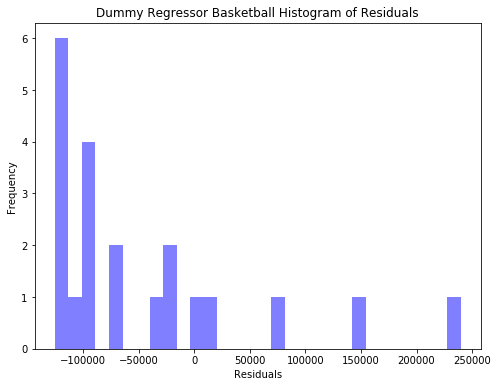

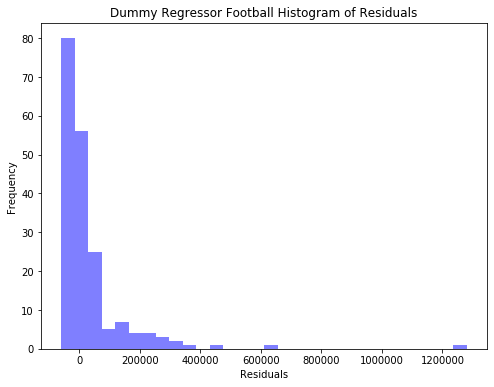

In [35]:
create_residual_histogram('Dummy Regressor Basketball', y_actual_drbb, y_pred_drbb)
create_residual_histogram('Dummy Regressor Football', y_actual_drfb, y_pred_drfb)

**Linear Regression - No Scaling- All Features**

In [73]:
#linear regresssion - with Standard scaling

def linear_reg(name, X_train, y_train, X_valid, y_valid, X_test, y_test):
    name = name
   
     #Create an instance of the LinearRegression model
    model = LinearRegression()


    #Train the model on the training set
    model.fit(X_train, y_train)
   
    #  # Make predictions on the train set
    # y_train_pred = model.predict(X_train)

    # Make predictions on the validation set
    y_val_pred = model.predict(X_valid)
    
    #Reverse the log transformation to obtain predictions on the original scale
    y_val_pred = np.expm1(y_val_pred)
    y_val_actual = np.expm1(y_valid)


    # Make predictions on the test set
    y_test_pred = model.predict(X_test)
    
    #Reverse the log transformation to obtain predictions on the original scale
    y_test_pred = np.expm1(y_test_pred)   
    y_test_pred = np.round(y_test_pred ,0)
    
    y_test_actual = np.expm1(y_test)

    # Use the coefficients and intercept obtained from the linear regression model
    slope = model.coef_[0]
    intercept = model.intercept_

# Calculate the corresponding y values for the regression line based on the range of  data
    min_value = min(X_train.min().min(), X_valid.min().min(), X_test.min().min())
    max_value = max(X_train.max().max(), X_valid.max().max(), X_test.max().max())
    x_range = np.linspace(min_value, max_value, 100)
    regression_line = slope * x_range + intercept

 
    mae, mse, rmse, r2 = regression_results(y_test_actual, y_test_pred)

    # Huber loss function-for loss values less than delta, use the MSE; for loss values greater than delta, use the MAE.
    
    def Huber(y, y_pred, delta):
        condition = np.abs(y - y_pred) < delta
        l = np.where(condition, 0.5 * (y - y_pred) ** 2,
                     delta * (np.abs(y - y_pred) - 0.5 * delta))
        return np.sum(l) / np.size(y)

    delta= 1.0
    huber_loss = Huber(y_test_actual, y_test_pred, delta = delta)
    return {
        # "Model Name": "Linear Regression",
        "{} Results".format(name): {
            "Model Name": "Linear Regression-NoScaling",
            "test R_Squared": r2,
            "test RMSE": round(rmse,4),
            "test MSE": mse,
            "test MAE": mae, 
            'test huber_loss': round(huber_loss,4)
        }
    }, y_test_pred, y_test_actual, regression_line



In [72]:
#getting test actual and predicted
results_bblr, y_test_actual_bblr, y_test_pred_bblr, regression_line = linear_reg ('basketball',X_train_bb, 
                                                                               y_train_bb, 
                                                                               X_valid_bb, 
                                                                               y_valid_bb, 
                                                                               X_test_bb, 
                                                                               y_test_bb)


results_fblr, y_test_actual_fblr, y_test_pred_fblr, regression_line = linear_reg ('football',X_train_fb, 
                                                                               y_train_fb, 
                                                                               X_valid_fb, 
                                                                               y_valid_fb, 
                                                                               X_test_fb, 
                                                                               y_test_fb)

linreg_bb = pd.DataFrame(results_bblr)
linreg_fb = pd.DataFrame(results_fblr)

display(linreg_bb.T)
display(linreg_fb.T)

,Model Name,huber_loss,test MAE,test MSE,test RMSE,test R_Squared
basketball Results,Linear Regression-NoScaling,55714.2143,55714.7143,4760795395.381,68998.5173,0.4791


,Model Name,huber_loss,test MAE,test MSE,test RMSE,test R_Squared
football Results,Linear Regression-NoScaling,57372.1368,57372.6368,13942467345.636801,118078.2255,0.2305


In [ ]:

plot_regression_results(y_test_actual_bblr,  y_test_pred_bblr, 'Linear Regression (NoScaling) Basketball-')
plot_regression_results(y_test_actual_fblr, y_test_pred_fblr, 'Linear Regression (NoScaling) Football-')



**Linear Regression - with Standard Scaling- All Features**

In [58]:
#linear regresssion - with Standard scaling

def linear_reg_scaled(name, X_train, y_train, X_valid, y_valid, X_test, y_test):
    name = name
    #Initialize the scaler
    scaler = StandardScaler()
    # scaler = MinMaxScaler()
    
    # Fit_transform  scaler on training, validation, test data 
    X_train_scaled = scaler.fit_transform(X_train) #For training data
    X_valid_scaled = scaler.transform(X_valid)  # For validation data
    X_test_scaled = scaler.transform(X_test)    # For test data

     #Create an instance of the LinearRegression model
    model = LinearRegression()


    #Train the model on the training set
    model.fit(X_train_scaled, y_train)
   
    #  # Make predictions on the train set
    # y_train_pred = model.predict(X_train_scaled)

    # Make predictions on the validation set
    y_val_pred = model.predict(X_valid_scaled)
    
    #Reverse the log transformation to obtain predictions on the original scale
    y_val_pred = np.expm1(y_val_pred)
    y_val_actual = np.expm1(y_valid)


    # Make predictions on the test set
    y_test_pred = model.predict(X_test_scaled)
    
    #Reverse the log transformation to obtain predictions on the original scale
    y_test_pred = np.expm1(y_test_pred)   
    y_test_pred = np.round(y_test_pred ,0)
    
    y_test_actual = np.expm1(y_test)

    # Use the coefficients and intercept obtained from the linear regression model
    slope = model.coef_[0]
    intercept = model.intercept_

# Calculate the corresponding y values for the regression line based on the range of  data
    min_value = min(X_train_scaled.min(), X_valid_scaled.min(), X_test_scaled.min())
    max_value = max(X_train_scaled.max(), X_valid_scaled.max(), X_test_scaled.max())
    x_range = np.linspace(min_value, max_value, 100)
    regression_line = slope * x_range + intercept

 
    
    mae, mse, rmse, r2 = regression_results(y_test_actual, y_test_pred)

  # Calculate Huber loss
    huber_loss_value = huber_loss(y_test_actual, y_test_pred)
    
    return {
        # "Model Name": "Linear Regression with Scaling",
        "{} Results".format(name): {
            "Model Name": "Linear Regression with Scaling",
            "test R_Squared": r2,
            "test RMSE": round(rmse,4),
            "test MSE": mse,
            "test MAE": mae,
            'test huber_loss': huber_loss_value
        }
    }, y_test_pred, y_test_actual, regression_line



In [59]:

# X_train_bb, y_train_bb, X_valid_bb, y_valid_bb, X_test_bb, y_test_bb 
# X_train_fb, y_train_fb, X_valid_fb, y_valid_fb, X_test_fb, y_test_fb 

In [60]:
results_bblrs, y_test_actual_bblrs, y_test_pred_bblrs, regression_line = linear_reg_scaled ('basketball',X_train_bb, 
                                                                               y_train_bb, 
                                                                               X_valid_bb, 
                                                                               y_valid_bb, 
                                                                               X_test_bb, 
                                                                               y_test_bb)


results_fblrs, y_test_actual_fblrs, y_test_pred_fblrs, regression_line = linear_reg_scaled ('football',X_train_fb, 
                                                                               y_train_fb, 
                                                                               X_valid_fb, 
                                                                               y_valid_fb, 
                                                                               X_test_fb, 
                                                                               y_test_fb)

linregs_bb = pd.DataFrame(results_bblrs)
linregs_fb = pd.DataFrame(results_fblrs)

display(linregs_bb.T)
display(linregs_fb.T)

NameError: name 'huber_loss' is not defined

In [ ]:
plot_regression_results(y_test_actual_bblrs,  y_test_pred_bblrs, 'Linear Regression (Scaling) Basketball-')
plot_regression_results(y_test_actual_fblrs, y_test_pred_fblrs, 'Linear Regression (Scaling) Football-')

In [ ]:
#with Cross-Fold Validation
cv = 6
lm = LinearRegression()
scores = cross_val_score(lm, X_train_bb, y_train_bb, scoring='r2', cv=cv)
scores  

In [ ]:
# number of features in X_train_bb
len(X_train_bb.columns)

In [ ]:
# step-1: create a cross-validation scheme
folds = KFold(n_splits = 5, shuffle = True, random_state = 100)

# step-2: specify range of hyperparameters to tune
hyper_params = [{'n_features_to_select': list(range(1, 15))}]


# step-3: perform grid search
# 3.1 specify model
lm = LinearRegression()
lm.fit(X_train_bb, y_train_bb)
rfe = RFE(lm)             

# 3.2 call GridSearchCV()
model_cv = GridSearchCV(estimator = rfe, 
                        param_grid = hyper_params, 
                        scoring= 'r2', 
                        cv = folds, 
                        verbose = 1,
                        return_train_score=True)      

# fit the model
model_cv.fit(X_train_bb, y_train_bb)   

In [ ]:
# cv results
cv_results = pd.DataFrame(model_cv.cv_results_)
cv_results

In [ ]:
# plotting cv results
plt.figure(figsize=(16,6))

plt.plot(cv_results["param_n_features_to_select"], cv_results["mean_test_score"])
plt.plot(cv_results["param_n_features_to_select"], cv_results["mean_train_score"])
plt.xlabel('number of features')
plt.ylabel('r-squared')
plt.title("Optimal Number of Features")
plt.legend(['test score', 'train score'], loc='upper left')